In [1]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")

Imports done


Temperature at 25 centimetres is:  17.0  degrees celsius


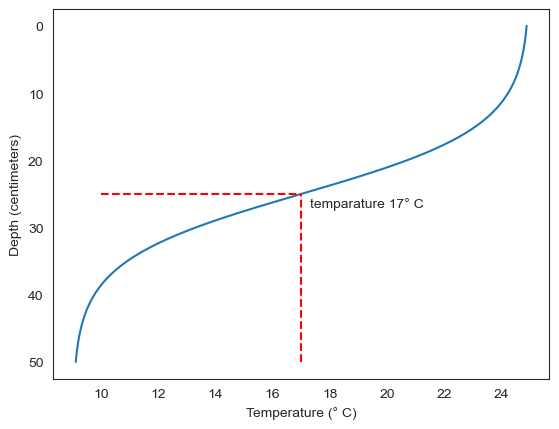

In [2]:
def g_gp(x,v):
    """
    Generative process, equation of sensory mapping: g_gp(x,v) at point x    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Hidden causal state, in this example not used
        
    OUTPUT:
        g_gp(x,v) - Temperature in degrees celsius
        
    """

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x,v):
    """
    Partial derivative of generative process towards x, equation of sensory mapping: g'_gp(x,v) at point x    
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g'_gp(x,v) - first partial derivative of generative process towards x
        
    """
    
    return -16/5 * np.exp(5-x/5) / (1+np.exp(5-x/5))**2

def ddg_gp(x,v):
    """
    Double partial derivative of generative process towards x, equation of sensory mapping: g''_gp(x) at point x  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g''_gp(x,v) - second partial derivative of generative process towards x
        
    """
    
    return (32*np.exp((2*x)/5+5))/(25*(np.exp(x/5)+np.exp(5))**3)-(16*np.exp(x/5+5))/(25*(np.exp(x/5)+np.exp(5))**2)

def dddg_gp(x,v):
    """
    3rd partial derivative of generative process towards x, equation of sensory mapping: g'''_gp(x) at point x  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g'''_gp(x,v) - third partial derivative of generative process towards x
        
    """
    
    return -16*np.exp(x/5+5)*(np.exp((2*x)/5)-4*np.exp(x/5+5)+np.exp(10))/(125*(np.exp(x/5)+np.exp(5))**4)

def ddddg_gp(x,v):
    """
    4th partial derivative of generative process towards x, equation of sensory mapping: g''''_gp(x) at point x  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g''''_gp(x,v) - 4th partial derivative of generative process towards x
        
    """
    
    return (16*np.exp(x/5+5)*(np.exp((3*x)/5)-11*np.exp((2*x)/5+5)+11*np.exp(x/5+10)-np.exp(15)))/(625*(np.exp(x/5)+np.exp(5))**5)

# in case you wondered how to calculated all the derivatives in an easy way: https://www.derivative-calculator.net/

# Show the temperature curve
x_show = np.arange (-0,50,0.01)
y_show = g_gp(x_show,0)
dy_show = dg_gp(x_show,0)
plt.plot(y_show, x_show)
#plt.plot(dy_show, x_show)
plt.ylabel('Depth (centimeters)')
plt.xlabel('Temperature (° C)')
plt.gca().invert_yaxis()
plt.vlines(17, 50, 25, colors='r', linestyles='dashed')
plt.hlines(25, 10,17, colors='r', linestyles='dashed')
plt.text(17.3,27,"temparature 17° C")
plt.show;

print('Temperature at 25 centimetres is: ', g_gp(25,0), ' degrees celsius')

In [3]:
a_gp=0
b_gp=1
def f_gp(x, v, u):
    """
    Generative process, equation of motion: f_gp(x,u)    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Causal state
        u       - Control signal
        
    OUTPUT:
        f_gp(x,v,u) - motion (speed) of the hidden state (depth) 
        
    """
    return a_gp*x + b_gp*u

def df_gp(x, v, u):
    """
    Partial derivative of generative process towards x, equation of motion: f'_gp(x,v,u) at point x    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Causal state
        u       - Control signal
        
    OUTPUT:
        df_gp(x, u) - first derivative of the equation of motion towards x
        
    """
    return a_gp

In [4]:
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 10+dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points
print ('Amount of data points: ', N)
print ('Starting with', t[0:5])
print ('Ending with', t[N-5:N])
print ('Data elements', np.size(t))

Amount of data points:  2002
Starting with [0.    0.005 0.01  0.015 0.02 ]
Ending with [ 9.985  9.99   9.995 10.    10.005]
Data elements 2002


In [5]:
# Support functions for generalised coordinates of motion

def makeNoise(C,s2,t):
    """
    Generate random noise series with temporal smoothness with desired covariance matrix
    Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)
    
    INPUTS:
        C       - desired covariance matrix
        s2      - smoothness parameter (>0), variance of the filter (sigma^2)
                  - s2 <= 1e-5 -> produces white noise
        t       - timeline 
        
    OUTPUT:
        ws       - noise sequence with temporal smoothness
    """
    
    if np.size(C)== 1:
        n = 1
    else:
        n = C.shape[1]  # dimension of noise
        
    # Create the white noise with correct covariance
    N = np.size(t)      # number of elements
    L =cholesky(C, lower=True)  #Cholesky method
    w = np.dot(L,np.random.randn(n,N))
    
    if s2 <= 1e-5: # return white noise
        return w
    else: 
        # Create the noise with temporal smoothness
        P = toeplitz(np.exp(-t**2/(2*s2)))
        F = np.diag(1./np.sqrt(np.diag(np.dot(P.T,P))))
        K = np.dot(P,F)
        ws = np.dot(w,K)
        return ws

def temporalC(p,s2):
    """
    Construct the temporal covariance matrix S for noise with embedding order p and smoothness parameter s
    
    Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)
    
    INPUTS:
        p       - embedding order (>0)
        s2      - smoothness parameter (>0), variance of the filter (sigma^2)
        
    OUTPUT:
        S       - temporal covariance matrix ((p+1) x (p+1))
    """ 

    q = np.arange(p+1)
    
    r = np.zeros(1+2*(p))
    r[2*q] = np.cumprod(1-2*q)/(2*s2)**(q)    
    
    S = np.empty([0,p+1])

    for i in range(p+1):
        S = np.vstack([S,r[q+i]])
        r = -r
           
    return S 

def derivativeD(p):
    """
    Construct derivative operator with embedding order p 
    Shifts all variables of a vector up by one and adds a zero at the bottom 
    
    Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)
    
    INPUTS:
        p       - embedding order (>0)
        
    OUTPUT:
        D       - derivative matrix ((p+1) x (p+1))
    """ 
    D = toeplitz(np.zeros([1,p+1]),np.append(np.array([0,1]),np.zeros([1,p-1])))
           
    return D

def generalize_extend(y,p):
    """
    Construct generalised value with embedding order p 
    By [y,0,0...]
    
    INPUTS:
        y       - Input sensory signal
        p       - embedding order (>0)
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')    
    
    if np.shape(y)==(p+1, 1):
        # Generalised value, use it
        y_tilde=y;
        return y_tilde
    
    # Generalize sensory observation by adding zero's
    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y

    return y_tilde

def sensor_generalize_exact(y,p,x,v,u):
    """
    Construct generalised sensory observations with embedding order p 
    Generalize sensory observation by calculating the exact value 
    
    For this example it has been calculated upto 3 derivatives

    INPUTS:
        y       - Input sensory signal
        p       - embedding order (>0)
        x       - Hidden state, needed to calculate the exact higher derivatives
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')       

    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y
    if p>=1:
        y_tilde[1] = dg_gp(x,v)*f_gp(x,v,u) 
    if p>=2:
        y_tilde[2] = ddg_gp(x,v)*f_gp(x,v,u)**2 + dg_gp(x,v)*df_gp(x,v,u)*f_gp(x,v,u)
    if p>=3:
        y_tilde[3] = dddg_gp(x,v)*f_gp(x,v,u)**3 + 2*ddg_gp(x,v)*f_gp(x,v,u)**2*df_gp(x,v,u) + df_gp(x,v,u)*(ddg_gp(x,v)*f_gp(x,v,u)**2 + dg_gp(x,v)*df_gp(x,v,u)*f_gp(x,v,u))
    
    return y_tilde

def sensor_generalize_backward(y,i,p):
    """
    Construct generalised sensory observations with embedding order p 
    Generalize sensory observation by approximating the derivaties from past observations
    
    For this example it has been calculated upto 4 derivatives
    
    INPUTS:
        y       - Input sensory signal (array including all history thus far)
        i       - Current timestamp, so y[i] is the current non-generalised sensory signal
        p       - embedding order (>=0)
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')    
    
    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y[i]
    if p>=1:
        y_tilde[1] = (y[i]-y[i-1])/dt
        #print('Generalise backward input : ', y[i],' + ',y[i-1])
    if p>=2 and i>=2:
        y_tilde[2] = (y[i]-2*y[i-1]+y[i-2])/dt**2
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2])
    if p>=3 and i>=3:
        y_tilde[3] = (y[i]-3*y[i-1]+3*y[i-2]-y[i-3])/dt**3
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2],' + ',y[i-3])
    if p>=4 and i>=4:
        y_tilde[4] = (y[i]-4*y[i-1]+6*y[i-2]-4*y[i-3]+y[i-4])/dt**4
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2],' + ',y[i-3],' + ',y[i-4])
          
    return y_tilde

def standard_vec(p):
    x = np.zeros((p+1,1))
    x[0] = 1
    return x

def standard_vec_inv(p):
    x = np.ones((p+1,1))
    x[0] = 0
    return x

def ones_vec(p):
    x = np.ones((p+1,1))
    return x

def fwd_model(p,x,v,u,fwd_method):
    """
    Construct the forward model embedding order p 
    
    For this example it has been calculated upto 3 derivatives

    INPUTS:
        p          - embedding order (>0)
        x          - Hidden state
        v          - Hidden cause
        u          - Control signal
        fwd_method - Method
        
    OUTPUT:
        fwd - Forward model, note: for this specific notebook example
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order forward model < 0')       
    if fwd_method == 'sign':
        fwd = -1 * np.ones((p+1,1))
    elif fwd_method == 'exact':        
        fwd = np.zeros((p+1,1))
        if p>=1:
            fwd[1] = b_gp*dg_gp(x,v)
        if p>=2:
            fwd[2] = 2*b_gp*f_gp(x,v,u)*ddg_gp(x,v) +b_gp*df_gp(x,v,u)*dg_gp(x,v)
        if p>=3:
            fwd[3] = 3*b_gp*f_gp(x,v,u)**2*dddg_gp(x,v)+4*df_gp(x,v,u)*b_gp*f_gp(x,v,u)*dg_gp(x,v)+2*df_gp(x,v,u)*b_gp*f_gp(x,v,u)*ddg_gp(x,v)+df_gp(x,v,u)**2*b_gp*dg_gp(x,v)
    elif fwd_method == 'sign+':        
        fwd = np.zeros((p+1,1))
        if p>=1:
            fwd[1] = np.sign(dg_gp(x,v))
        if p>=2:
            fwd[2] = np.sign(ddg_gp(x,v))
        if p>=3:
            fwd[3] = np.sign(dddg_gp(x,v))
    else:
        raise ValueError('Unknown method to create forward model')     

    return fwd  

In [6]:
class ai_capsule():
    """
        Class that constructs a group of neurons that perform Active Inference for one hidden state, one sensory input, one prior
        In neurology it could e.g. represent a (micro) column or a neuron assembly

        Version 0.3 including generalised coordinates of motion and action
    """
    def __init__(self, dt, mu_x_init, p, Sigma_w, Sigma_z, a_mu, a_u, s2_w, s2_z, fwd_method, actiontime):  
        
        self.dt = dt    # integration step
        self.mu_x= mu_x_init # initializing the hidden state, in generalised coordinates of motion
        self.u = 0      # initialize the control signal as 0, no action
        self.p = p      # embedding order, number of derevatives in generalised coordinates of motion
        self.Sigma_w = Sigma_w # Estimated variance of the hidden state equals variance of the prior
        self.Sigma_z = Sigma_z # Estimated variance of the sensory observation 
        self.s2_w = s2_w # Estimated variance of the Gaussian filter used to create the smoothened noise w
        self.s2_z = s2_z # Estimated variance of the Gaussian filter used to create the smoothened noise z
        self.alpha_mu = a_mu # perception learning rate
        self.alpha_u = a_u # action learning rate 
        self.D = derivativeD(self.p)
        self.I = np.identity(self.p+1)
        print(self.I)
        self.Iv = np.ones((p+1,1))
        self.Pi_w = inv(np.kron(temporalC(self.p,self.s2_w),self.Sigma_w)) # precision matrix of smoothened noise w
        self.Pi_z = inv(np.kron(temporalC(self.p,self.s2_z),self.Sigma_z)) # precision matrix of smoothened noise z
        self.std_vec_inv=standard_vec_inv(p)
        self.std_vec=standard_vec(p)
        self.fwd_method = fwd_method
        self.actiontime = actiontime
        
        # Generative model parameters
        self.a=-1 # generative model function of motion is -mu_x + mu_v, hence a = -1
        self.b=1 # generative model function of motion is -mu_x + mu_v, hence b = 1
        #self.c=1 # uncomment in case you want to tst a linear model for sensory observations
        #self.Ctilde= self.c * self.I # uncomment in case you want to tst a linear model for sensory observations
    
    def g(self,x,v):
        """
            equation of sensory mapping of the generative model: g(x,v) at point x 
            Given as input for this example equal to the true generative process g_gp(x,v)
        """
        return g_gp(x,v)
    
    def dg(self, x,v):
        """
            Partial derivative of the equation of sensory mapping of the generative model towards x: g'(x,v) at point x 
            Given as input for this example equal to the true derivative of generative process dg_gp(x,v)
        """
        return dg_gp(x,v)
    
    def f(self,x,v):
        """
            equation of motion of the generative model: f(x,v) at point x 
            f(x,v) = a* mu_x + b* mu_v, where a = -1, b=1
        """
        return self.a*x + self.b*v
    
    def df(self,x,v):
        """
            Partial derivative of equation of motion of the generative model: f'(x,v) at point x 
        """
        return self.a
    
    def ai_step (self, i, mu_v, y):
        """
        Perform active inference step   

        INPUTS:
            i       - tic, timestamp
            mu_v    - Hierarchical prior input signal (mean) at timestamp,  in generalized coordinates of motion
            y       - sensory input signal at timestamp, in generalized coordinates of motion

        INTERNAL:
            mu_x      - Belief or hidden state estimation, in generalized coordinates of motion

        """

        #-------------------------------#
        #                               #
        #           Prediction          #
        #                               #
        #-------------------------------#
        
        # Note that the predictions are in generalized coordinates of motion  
        mu_x_hat = self.std_vec*self.f(self.mu_x[0],mu_v[0]) + self.std_vec_inv * self.df(self.mu_x[0],mu_v[0]) * self.mu_x
        mu_y_hat = self.std_vec*self.g(self.mu_x[0],mu_v[0]) + self.std_vec_inv * self.dg(self.mu_x[0],mu_v[0]) * self.mu_x
        
        

        # print(self.f(self.mu_x[0],mu_v[0]), "pies")
        # print(self.df(self.mu_x[0],mu_v[0]), "poep")
        print(self.mu_x, "mu_x")
        # print(mu_x_hat, "mu_x_hat")
        # print(mu_y_hat, "mu_y_hat")
        #-------------------------------#
        #                               #
        #        Prediction Error       #
        #                               #
        #-------------------------------#

        # Note that the predictions erros are in generalized coordinates of motion 
        
        eps_x = self.D.dot(self.mu_x) - mu_x_hat 
        eps_y = y - mu_y_hat #prediction error sensory observation  
        
        # In case a linear state space model is used the below calculation is equivalent
        #eps_x = (self.D-self.Atilde).dot(self.mu_x) - mu_v  # prediction error hidden state
        #eps_y = y - self.Ctilde.dot(self.mu_x) #prediction error sensory observation

        #-------------------------------#
        #                               #
        # Prediction Error minimization #
        #                               #
        #-------------------------------#            
     
        # Calculate Free Energy to report out
        F= 0.5*( eps_x.T.dot(self.Pi_w).dot(eps_x) + eps_y.T.dot(self.Pi_z).dot(eps_y)).item(0) 
        # Note, the item(0) is needed to translate the python matrix result to a scaler, e.g. [[1]] to 1
        
        # Gradient descent inference/perception 
        # Note that in this example the function of motion is linear and hence can be calculated as below
        Atilde=self.a * self.I
        dFdmu_x = (self.D-Atilde).T.dot(self.Pi_w).dot(eps_x) - (self.dg(self.mu_x[0],mu_v[0]) * self.I ).T.dot(self.Pi_z).dot(eps_y)
        dmu_x = np.dot(self.D,self.mu_x) - self.alpha_mu * dFdmu_x  
        self.mu_x = self.mu_x + self.dt * dmu_x
        
        # print(dFdmu_x)
        # print(dmu_x)
        # In case a linear state space model is used with linear equation of sensory mapping the below calculation is equivalent
        #Ctilde=self.c * self.I
        #dFdmu_x = (self.D-Atilde).T.dot(self.Pi_w).dot(self.eps_x) - Ctilde.T.dot(self.Pi_z).dot(self.eps_y)
        
        # Gradient descent action 
        if i>self.actiontime:
            fwd=fwd_model(self.p, self.mu_x[0], mu_v[0], self.u, self.fwd_method)          
            dFdu = fwd.T.dot(self.Pi_z).dot(eps_y).item(0)
            du = -self.alpha_u * dFdu  
            self.u = self.u + self.dt * du
        else:
            self.u=0
        

        return self.u, F, self.mu_x[0] , self.g(self.mu_x[0],mu_v[0])
    

In [7]:
def simulation (v, mu_v, x_init, Sigma_w, Sigma_z, noise_method, a_mu, a_u, p, gen_y_method, fwd_method, actiontime):
    """
    Simulation for perceptual inference in a dynamic environment with generalised coordinates     
   
    INPUTS:
        v             - Hydars actual desired depth, used in generative model
        mu_v          - Hydars prior belief/hypotheses of the desired depth (time series)
        x_init        - Hydars actual starting depth, used in generative model
        Sigma_w       - Variance of the hidden state 
        Sigma_z       - Variance of the sensory observation 
        noise_method  - white, smooth or none
        a_mu          - Learning rate for mu
        a_u           - Learning rate for u
        p             - Embedding order of generalised motions of the generative model
        gen_y_method  - Method to generalize the sensory observations: exact, backward, extend
        fwd_method    - Method for the foward model: exact, sign 
    VARIABLES:
        s2_w          - The variance of the Gaussian filter used to create the smoothened noise w
        s2_z          - The variance of the Gaussian filter used to create the smoothened noise z
        
    """
    
    # Init tracking
    mu_x = np.zeros(N) # Belief or estimation of hidden state 
    F = np.zeros(N) # Free Energy of AI neuron
    mu_y = np.zeros(N) # Belief or prediction of sensory signal
    u = np.zeros(N) # control signal


    # Construct noise signals with temporal smoothness:
    np.random.seed(42)
    if noise_method == 'white':
        s2_w= 1e-5
        s2_z= 1e-5
    elif noise_method == 'smooth':
        s2_w= 1/2000
        s2_z= 1/2000
        # And generate the smooth noise
        w = makeNoise(Sigma_w,s2_w,t)
        z = makeNoise(Sigma_z,s2_z,t)
    else: #no noise
        s2_w= 1/64
        s2_z= 1/64
    
    # Init the generalised process
    x = np.zeros(N) # True hidden state
    y = np.zeros(N) # Sensory signal as input to AI neuron
    x[0] = x_init
    if noise_method == 'white':
        y[0]=g_gp(x[0],v) + np.random.randn(1) * Sigma_z
    elif noise_method == 'smooth':
        y[0]=g_gp(x[0],v)+ z[0,0] 
    else: #no noise
        y[0]=g_gp(x[0],v)

    # Create active inference neuron
    
    if p<=0:
        # Not generalised
        raise ValueError('Select embedding order p > 0') 
    else:
        # Generalised
        # initializing the initial hidden state by Hydars best guess: hierarchical prior
        mu_x_init_tilde = generalize_extend(mu_v[0],p) # generalize the prior
        print(mu_x_init_tilde, "mu_x_init_tilde")
        capsule = ai_capsule(dt, mu_x_init_tilde, p, Sigma_w, Sigma_z, a_mu, a_u, s2_w, s2_z, fwd_method, actiontime) 

    ssim = time.time() # start sim
    
    # Simulation

    for i in np.arange(1,N):
        # Generative process
        if noise_method == 'white':
            x_dot= f_gp(x[i-1],v, u[i-1]) + np.random.randn(1) * Sigma_w
            x[i]= x[i-1] + dt*x_dot
            y[i] = g_gp(x[i],v) + np.random.randn(1) * Sigma_z
        elif noise_method == 'smooth':
            x_dot= f_gp(x[i-1],v,u[i-1]) + w[0,i]
            x[i]= x[i-1] + dt*x_dot
            y[i] = g_gp(x[i],v) + z[0,i]
        else: #no noise
            x_dot=f_gp(x[i-1],v,u[i-1])
            x[i]= x[i-1] + dt*x_dot
            y[i] = g_gp(x[i],v)



        # Create generalize sensory observations 
        if gen_y_method=='exact':
            y_tilde = sensor_generalize_exact(y[i],p,x[i],v,u[i-1])
            #print(y_tilde)
        elif gen_y_method=='backward':
            y_tilde = sensor_generalize_backward(y,i,p)
        elif gen_y_method=='extend':
            y_tilde = generalize_extend(y[i],p)
        else:
            raise ValueError('Unknown method to create sensory observation in generalised coordinates of motion')     
        
        # Active inference step       
        mu_v_tilde=generalize_extend(mu_v[i],p)
        u[i], F[i], mu_x[i], mu_y[i] = capsule.ai_step(i,mu_v_tilde,y_tilde)

    
    # Print the results
    tsim = time.time() - ssim
    #print('Simulation time: ' + "%.2f" % tsim + ' sec' )

    return F, mu_x, mu_y, x, y, u


x_init = 30.0 # generative process initial depth Hydar
v = 0 # in this example v is not used
mu_v = np.ones(N) * 25.0 # generative model, Hydars prior belief of the (target) depth
actiontime=0.20
# simulation parameters (v, mu_v, x_init, Sigma_w, Sigma_z, noise_method, a_mu, a_u, p, gen_y_method, fwd_method, actiontime):
F1, mu_x1, mu_y1, x1, y1, u1 = simulation(v,mu_v,x_init,0.1,0.1,'no noise',1,50,3,'exact','exact', actiontime*N) # 



[[25.]
 [ 0.]
 [ 0.]
 [ 0.]] mu_x_init_tilde
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[25.]
 [ 0.]
 [ 0.]
 [ 0.]] mu_x
[[2.52218162e+01]
 [0.00000000e+00]
 [2.31058579e-03]
 [0.00000000e+00]] mu_x
[[ 2.54162440e+01]
 [-1.66354956e-02]
 [ 4.32678755e-03]
 [-1.73406756e-04]] mu_x
[[ 2.55876835e+01]
 [-4.64982111e-02]
 [ 6.16058792e-03]
 [-4.85142687e-04]] mu_x
[[ 2.57398273e+01]
 [-8.67877060e-02]
 [ 7.90283913e-03]
 [-9.06375724e-04]] mu_x
[[ 2.58757588e+01]
 [-1.35208834e-01]
 [ 9.62675170e-03]
 [-1.41346610e-03]] mu_x
[[ 2.59980447e+01]
 [-1.89884868e-01]
 [ 1.13908948e-02]
 [-1.98707418e-03]] mu_x
[[ 2.61088164e+01]
 [-2.49284560e-01]
 [ 1.32417429e-02]
 [-2.61141149e-03]] mu_x
[[ 2.62098419e+01]
 [-3.12161294e-01]
 [ 1.52158162e-02]
 [-3.27361578e-03]] mu_x
[[ 2.63025862e+01]
 [-3.77502572e-01]
 [ 1.73414680e-02]
 [-3.96323214e-03]] mu_x
[[ 2.63882635e+01]
 [-4.44488195e-01]
 [ 1.96403695e-02]
 [-4.67178347e-03]] mu_x
[[ 2.64678804e+01]
 [-5.12455755e-01]
 [ 2.2

[[25.]
 [ 0.]] mu_x_init_tilde
[[1. 0.]
 [0. 1.]]
[[25.]
 [ 0.]] mu_x
[[25.14787749]
 [ 0.        ]] mu_x
[[ 2.52835981e+01]
 [-7.39387452e-03]] mu_x
[[ 2.54084441e+01]
 [-2.11851495e-02]] mu_x
[[25.52356511]
 [-0.04049388]] mu_x
[[25.62998896]
 [-0.0645439 ]] mu_x
[[25.7286328 ]
 [-0.09265127]] mu_x
[[25.82031369]
 [-0.1242139 ]] mu_x
[[25.90575862]
 [-0.15870225]] mu_x
[[25.98561378]
 [-0.19565098]] mu_x
[[26.06045312]
 [-0.23465152]] mu_x
[[26.13078618]
 [-0.27534551]] mu_x
[[26.19706515]
 [-0.31741891]] mu_x
[[26.25969126]
 [-0.36059678]] mu_x
[[26.31902046]
 [-0.40463871]] mu_x
[[26.3753686 ]
 [-0.44933471]] mu_x
[[26.42901596]
 [-0.49450162]] mu_x
[[26.48021135]
 [-0.5399799 ]] mu_x
[[26.52917569]
 [-0.58563084]] mu_x
[[26.57610526]
 [-0.63133406]] mu_x
[[26.62117452]
 [-0.6769853 ]] mu_x
[[26.66453866]
 [-0.72249451]] mu_x
[[26.70633581]
 [-0.7677841 ]] mu_x
[[26.74668901]
 [-0.81278747]] mu_x
[[26.78570798]
 [-0.85744765]] mu_x
[[26.82349067]
 [-0.90171617]] mu_x
[[26.86012459]

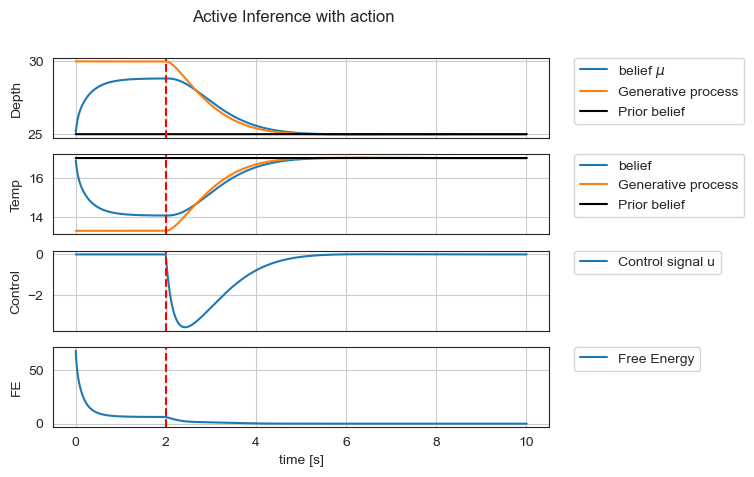

In [9]:
x_init = 30.0 # generative process initial depth Hydar
v = 0 # in this example v is not used
mu_v = np.ones(N) * 25.0 # generative model, Hydars prior belief of the (target) depth
actiontime=0.20
# simulation parameters (v, mu_v, x_init, Sigma_w, Sigma_z, noise_method, a_mu, a_u, p, gen_y_method, fwd_method, actiontime):
F1, mu_x1, mu_y1, x1, y1, u1 = simulation(v,mu_v,x_init,0.1,0.1,'no noise',1,50,1,'exact','exact', actiontime*N) # 

print('w covariance matrix = ')
print(np.kron(temporalC(1,1/64),0.1) )
print('z covariance matrix = ')
print(np.kron(temporalC(1,1/64),0.1) )

# Plot results:
fig, axes = plt.subplots(4, 1, sharex='col');
fig.suptitle('Active Inference with action');
axes[0].plot(t[1:],mu_x1[1:],label='belief $\mu$');
axes[0].plot(t[1:],x1[1:],label='Generative process');
axes[0].plot(t[1:],mu_v[1:],label='Prior belief', color='black')
axes[0].set_ylabel('Depth');
axes[0].axvline(x=actiontime*T, color='r', linestyle='--')
axes[0].ticklabel_format(useOffset=False)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[0].grid(1);

axes[1].plot(t[1:],mu_y1[1:],label='belief');
axes[1].plot(t[1:],y1[1:],label='Generative process');
axes[1].plot(t[1:],g_gp(mu_v[1:],0),label='Prior belief', color='black')
axes[1].axvline(x=actiontime*T, color='r', linestyle='--')
axes[1].set_ylabel('Temp');
axes[1].ticklabel_format(useOffset=False)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[1].grid(1);

axes[2].plot(t[1:],u1[1:],label='Control signal u');
axes[2].set_ylabel('Control');
axes[2].axvline(x=actiontime*T, color='r', linestyle='--')
axes[2].ticklabel_format(useOffset=False)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[2].grid(1);

#axes[3].semilogy(t[1:],F3[1:],label='p=3');
axes[3].plot(t[1:],F1[1:],label='Free Energy');
axes[3].axvline(x=actiontime*T, color='r', linestyle='--')
axes[3].set_xlabel('time [s]');
axes[3].set_ylabel('FE');
axes[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[3].grid(1);